# Motor data analysis

In [1]:
# Run to install PySerial library
#!conda install -c conda-forge pyserial

In [2]:
# Read the serial port and save to a csv (not working properly)
"""
import pandas as pd
import serial, time

file_name = 'motors_openLoop_noCharge1.csv'
ser=serial.Serial("/dev/ttyACM0",9600)

data = {'Time':list(),
        'Vel1':list(),'Vel2':list(),
        'SP1':list(),'SP2':list(),
        'Out1':list(),'Out2':list()}

while True:
    time.sleep(0.1)
    print("Waiting for messages from arduino..");
    read_ser=ser.readline().decode("utf-8")
    print(read_ser)
    
    read_list = read_ser.split(",")
    if len(read_list)==1:
        if(read_ser == "123456"):
            ser.close()
            new_data = pd.DataFrame(data=data, index='Time')
            new_data.to_csv(path_or_buf=file_name)
    else:
        i = -1
        for k in data.keys():
            i+=1
            data[k].append(read_list[i])
"""

'\nimport pandas as pd\nimport serial, time\n\nfile_name = \'motors_openLoop_noCharge1.csv\'\nser=serial.Serial("/dev/ttyACM0",9600)\n\ndata = {\'Time\':list(),\n        \'Vel1\':list(),\'Vel2\':list(),\n        \'SP1\':list(),\'SP2\':list(),\n        \'Out1\':list(),\'Out2\':list()}\n\nwhile True:\n    time.sleep(0.1)\n    print("Waiting for messages from arduino..");\n    read_ser=ser.readline().decode("utf-8")\n    print(read_ser)\n    \n    read_list = read_ser.split(",")\n    if len(read_list)==1:\n        if(read_ser == "123456"):\n            ser.close()\n            new_data = pd.DataFrame(data=data, index=\'Time\')\n            new_data.to_csv(path_or_buf=file_name)\n    else:\n        i = -1\n        for k in data.keys():\n            i+=1\n            data[k].append(read_list[i])\n'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.display import display
pd.options.display.max_columns = 10#None
pd.options.display.max_rows = 10
import os

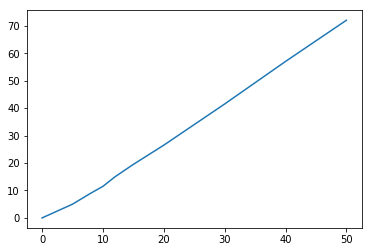

In [2]:
p = [0,5,8,10,12,15,20,30,40,50] # [%]
v = [0,5,9,11.5,15,19.5,26.5,41.5,57,72] # [rad/s]
plt.plot(p,v)

### Open loop

In [3]:
file_name = 'motors_openLoop_noCharge_181024_3.csv'

raw_data = pd.read_csv(file_name)
raw_data['Time'] = pd.to_datetime(raw_data['Time'],unit='s')
raw_data.set_index('Time',inplace=True)
raw_data.head()

,Vel1,Vel2,SP1,SP2,Out1,Out2
Time,,,,,,
1970-01-01 00:00:18.820,0.0,0.00,0.1,0.1,0.4,0.4
1970-01-01 00:00:19.830,0.0,0.00,0.1,0.1,0.4,0.4
1970-01-01 00:00:19.840,0.0,0.00,0.1,0.1,0.4,0.4
1970-01-01 00:00:19.850,0.0,0.06,0.1,0.1,0.4,0.4
1970-01-01 00:00:19.860,0.0,0.00,0.1,0.1,0.4,0.4


In [4]:
nans = [raw_data[k].isna().sum() for k in raw_data.keys()]
print(nans) # No NaN values, that is good.
print(len(raw_data))

[0, 0, 0, 0, 0, 0]
6850


<IPython.core.display.Javascript object>


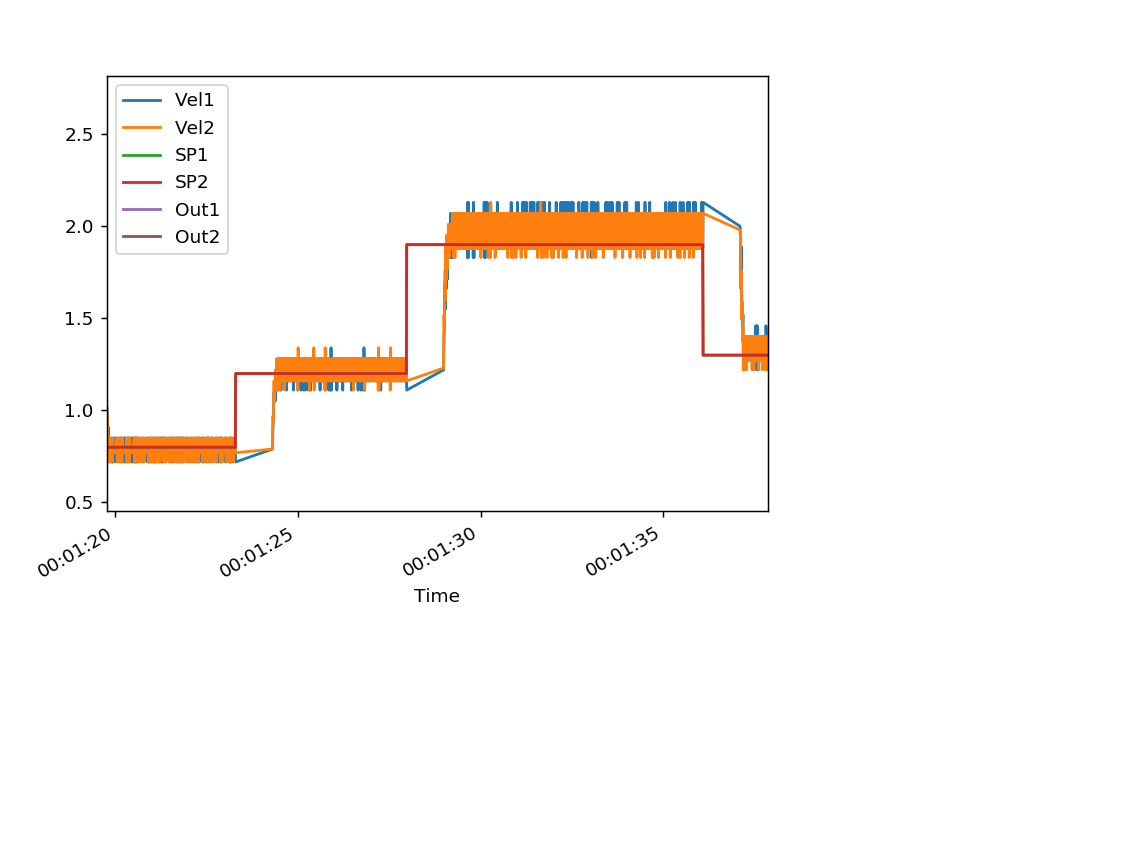

In [5]:
%matplotlib notebook
raw_data.plot()

In [6]:
# find the data of the big step (from 1.2 to 1.9)
print("\nUsed to find the data")
print(raw_data[4600:4730]) # used to find the data

print('\nFirst step steady state, median filter')
data1 = raw_data[4600:4730].median()
print(data1)
u1 = data1.SP1
print('\nU1',u1)
print('\nSecond step steady state, median filter')
data2 = raw_data[5000:5200].median()
print(data2)

# TF of motors
print("\nExtractint the 1st order trandfer function of the motors")
motor1 = {'k':0, 'tau':1, 'ts':0} # initialization
motor2 = motor1

motor1['k'] = (data2.Vel1- data1.Vel1)/(data2.SP1 - data1.SP1)
motor2['k'] = (data2.Vel2- data1.Vel2)/(data2.SP2 - data1.SP2)

y_tau_1 = data1.Vel1 + 0.632*(data2.Vel1- data1.Vel1)
y_tau_2 = data1.Vel2 + 0.632*(data2.Vel2- data1.Vel2)
print('\ny_tau_1', y_tau_1)
print('\ny_tau_2', y_tau_2)

print('\nFind initial time')

def gt_index(data,
             param=['Vel1', 'Vel2'],
             dr=[4730,5000], # data range
             th=[1.35,1.35]): #threshold
    t0 = {}
    t0_return = [0,0]
    t0['0'] = data[param[0]][dr[0]:dr[1]].gt(th[0]) # values grater than a threshold
    t0['1'] = data[param[1]][dr[0]:dr[1]].gt(th[1]) # values grater than a threshold
    found = [False, False]
    for x in range(0,(dr[1]-dr[0])):
        for i in range(2):
            if t0[str(i)][x]==True and not(found[i]):
                t0_return[i] = dr[0]+x
                found[i] = True
        if found[0]*found[1]:
            break
    return t0_return
t0 = gt_index(raw_data,param=['Vel1', 'Vel2'],dr=[4730,5000],th=[1.35,1.35])
t1 = gt_index(raw_data,param=['Vel1', 'Vel2'],dr=[4730,5000],th=[y_tau_1,y_tau_2])
print('\nt0 = ', t0)
print('\nt1 = ', t1)

Ts = 0.01 # Sampling time [s]
motor1['tau'] = (t1[0] - t0[0])*Ts
motor2['tau'] = (t1[1] - t0[1])*Ts

# Cannot compute the delay because there are some computations
# in the Arduino script that delay the communication.
# At least it will be 1 time the Ts
motor1['ts'] = 2*Ts
motor1['ts'] = 2*Ts

print('\nMotor1 = ', motor1)
print('\nMotor2 = ', motor2)


Used to find the data
                         Vel1  Vel2  SP1  SP2  Out1  Out2
Time                                                     
1970-01-01 00:01:25.600  1.28  1.22  1.2  1.2   4.8   4.8
1970-01-01 00:01:25.610  1.11  1.16  1.2  1.2   4.8   4.8
1970-01-01 00:01:25.620  1.28  1.28  1.2  1.2   4.8   4.8
1970-01-01 00:01:25.630  1.16  1.16  1.2  1.2   4.8   4.8
1970-01-01 00:01:25.640  1.28  1.28  1.2  1.2   4.8   4.8
...                       ...   ...  ...  ...   ...   ...
1970-01-01 00:01:26.900  1.28  1.28  1.2  1.2   4.8   4.8
1970-01-01 00:01:26.910  1.16  1.16  1.2  1.2   4.8   4.8
1970-01-01 00:01:26.920  1.28  1.28  1.2  1.2   4.8   4.8
1970-01-01 00:01:26.930  1.22  1.28  1.2  1.2   4.8   4.8
1970-01-01 00:01:26.940  1.16  1.16  1.2  1.2   4.8   4.8

[130 rows x 6 columns]

First step steady state, median filter
Vel1    1.28
Vel2    1.28
SP1     1.20
SP2     1.20
Out1    4.80
Out2    4.80
dtype: float64

U1 1.2

Second step steady state, median filter
Vel1    2.07
Vel2